# Table of Contents
* [1a. Periodic spinodal decomposition on a square domain](#1a.-Periodic-spinodal-decomposition-on-a-square-domain)
	* [Define $f_0$](#Define-$f_0$)
	* [Define the Equation](#Define-the-Equation)
	* [Solve the Equation](#Solve-the-Equation)
	* [Run the Example Locally](#Run-the-Example-Locally)
	* [Free Energy Plots](#Free-Energy-Plots)


# 1a. Periodic spinodal decomposition on a square domain

The free energy is given by,

$$ f_0\left[ c \left( \vec{r} \right) \right] =
   - \frac{A}{2} \left(c - c_m\right)^2
   + \frac{B}{4} \left(c - c_m\right)^4
   + \frac{c_{\alpha}}{4} \left(c - c_{\alpha} \right)^4
   + \frac{c_{\beta}}{4} \left(c - c_{\beta} \right)^4 $$

In FiPy we write the evolution equation as 

$$ \frac{\partial c}{\partial t} = \nabla \cdot  \left[
       D \left( c \right) \left( \frac{ \partial^2 f_0 }{ \partial c^2} \nabla c - \kappa \nabla \nabla^2 c \right)
   \right] $$

Let's start by calculating $ \frac{ \partial^2 f_0 }{ \partial c^2} $ using sympy. It's easy for this case, but useful in the general case for taking care of difficult book keeping in phase field problems.

In [1]:
%matplotlib inline

import sympy
import fipy as fp
import numpy as np
import matplotlib.pyplot as plt

In [2]:
c, rho_s, c_alpha, c_beta = sympy.symbols("c_var rho_s c_alpha c_beta")

In [3]:
f_0 = rho_s * (c - c_alpha)**2 * (c_beta - c)**2

In [4]:
print f_0

rho_s*(-c_alpha + c_var)**2*(c_beta - c_var)**2


In [5]:
sympy.diff(f_0, c, 2)

2*rho_s*((c_alpha - c_var)**2 + 4*(c_alpha - c_var)*(c_beta - c_var) + (c_beta - c_var)**2)

The first step in implementing any problem in FiPy is to define the mesh. For [Problem 1a]({{ site.baseurl }}/hackathon1/#a.-Square-Periodic) the solution domain is just a square domain, but the boundary conditions are periodic, so a `PeriodicGrid2D` object is used. No other boundary conditions are required.

In [6]:
mesh = fp.Grid2D(dx=0.5, dy=0.5, nx=40, ny=200) + (fp.Grid2D(dx=0.5, dy=0.5, nx=200, ny=40) + [[-40],[100]])

The next step is to define the parameters and create a solution variable.
Constants and initial conditions:
$c_{\alpha}$ and $c_{\beta}$ are concentrations at which the bulk free energy has minima.
$\kappa$ is the gradient energy coefficient.
$\varrho_s$ controls the height of the double-well barrier.

In [7]:
c_alpha = 0.3
c_beta = 0.7
kappa = 2.0
M = 5.0
c_0 = 0.5
epsilon = 0.01
rho_s = 5.0

c_var = fp.CellVariable(mesh=mesh, name=r"$c$", hasOld=True)

Now we need to define the initial conditions.

$c_{var}$ is a cell variable specifying concentrations at various points in the mesh. Here, it is the solution variable:

Set $c\left(x, y\right)$ such that

$$ c\left(x, y\right) = \bar{c}_0 + \epsilon_{\Box}[\cos(0.105x) \cos(0.11y) + [\cos(0.13x) \cos(.087y)]^2 + \cos(0.025x-0.15y) \cos(0.07x-0.02y)].$$

In [8]:
# array of sample c-values: used in f versus c plot
vals = np.linspace(-.1, 1.1, 1000)

c_var = fp.CellVariable(mesh=mesh, name=r"$c$", hasOld=True)

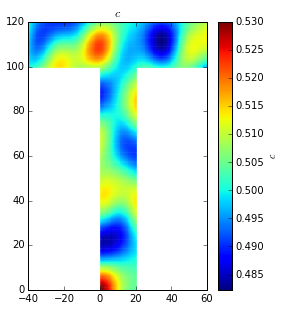

In [9]:
x , y = np.array(mesh.x), np.array(mesh.y)

c_var[:] = c_0 + epsilon * (np.cos(0.105 * x) * np.cos(0.11 * y) + \
                            (np.cos(0.13 * x) * np.cos(0.087 * y))**2 + \
                            + np.cos(0.025 * x - 0.15 * y) * np.cos(0.07 * x - 0.02 * y))

viewer = fp.Viewer(c_var)

## Define $f_0$

To define the equation with FiPy first define `f_0` in terms of FiPy. Recall `f_0` from above calculated using Sympy. Here we use the string representation and set it equal to `f_0_var` using the `exec` command.

In [10]:
out = sympy.diff(f_0, c, 2)

In [11]:
exec "f_0_var = " + repr(out)

In [12]:
#f_0_var = -A + 3*B*(c_var - c_m)**2 + 3*c_alpha*(c_var - c_alpha)**2 + 3*c_beta*(c_var - c_beta)**2
f_0_var

((((pow((0.3 - $c$), 2)) + (((0.3 - $c$) * 4) * (0.7 - $c$))) + (pow((0.7 - $c$), 2))) * 10.0)

In [13]:
# bulk free energy density
def f_0(c):
    return rho_s*((c - c_alpha)**2)*((c_beta-c)**2)
def f_0_var(c_var):
    return 2*rho_s*((c_alpha - c_var)**2 + 4*(c_alpha - c_var)*(c_beta - c_var) + (c_beta - c_var)**2)
# free energy
def f(c):
    return (f_0(c)+ .5*kappa*(c.grad.mag)**2)

# plot free energy density versus c
def plotf_c():
    plt.figure(1)
    plt.xlabel('c')
    plt.ylabel('f_0')
    plt.plot(vals, f_0(vals))
    plt.show()

Here, the elapsed time and total free energy at each time step are saved to separate lists. These lists are then updated in a text file.

In [14]:
# save elapsed time and free energy at each data point
f_data = []
time_data = []

def save_data(f, time):
    f_data.append(f.value)
    time_data.append(time)
    np.savetxt('1c.txt', zip(time_data, f_data))

## Define the Equation

In [15]:
eqn = fp.TransientTerm(coeff=1.) == fp.DiffusionTerm(M * f_0_var(c_var)) - fp.DiffusionTerm((M, kappa))
eqn

(TransientTerm(coeff=1.0) + (DiffusionTerm(coeff=[-((((((pow((0.3 - $c$), 2)) + (((0.3 - $c$) * 4) * (0.7 - $c$))) + (pow((0.7 - $c$), 2))) * 10.0) * 5.0))]) + DiffusionTerm(coeff=[5.0, 2.0])))

## Solve the Equation

To solve the equation a simple time stepping scheme is used which is decreased or increased based on whether the residual decreases or increases. A time step is recalculated if the required tolerance is not reached.

In [ ]:
elapsed = 0.0
steps = 0
dt = 0.01
total_sweeps = 2
tolerance = 1e-1
total_steps = 5000
duration = 1000.0
viewers = []

In [ ]:
c_var[:] = c_0 + epsilon * (np.cos(0.105 * x) * np.cos(0.11 * y) + \
                            (np.cos(0.13 * x) * np.cos(0.087 * y))**2 + \
                            + np.cos(0.025 * x - 0.15 * y) * np.cos(0.07 * x - 0.02 * y))
c_var.updateOld()
from fipy.solvers.pysparse import LinearLUSolver as Solver
solver = Solver()

while elapsed < duration and steps < total_steps:
    res0 = eqn.sweep(c_var, dt=dt, solver=solver)

    for sweeps in range(total_sweeps):
        res = eqn.sweep(c_var, dt=dt, solver=solver)

    if res < res0 * tolerance:
        steps += 1
        elapsed += dt
        dt *= 1.1
        c_var.updateOld()
        # record the volume integral of the free energy 
        save_data(f(c_var).cellVolumeAverage*mesh.numberOfCells, elapsed)
        # pickle the data on c as a function of space at this particular time
        fp.dump.write({'time' : steps, 'var': c_var}, '1cpickles/1c{0}.pkl'.format(steps))
        if (steps%(total_steps/10)==0):
            print steps
            print elapsed
            
            
            # create a viewer based on the pickled data
            viewers.append(fp.Viewer((fp.dump.read('1cpickles/1c{0}.pkl'.format(steps))['var']),
                        datamin=.448, datamax =.455,
                        title = 'Step: {0} Time: {1}'.format(steps, "%0.2f" %elapsed)))
    else:
        dt *= 0.8
        c_var[:] = c_var.old

viewer.plot()
print 'elapsed_time:',elapsed

## Free Energy Plots

In [ ]:
plotf_c()

plt.figure(3)
plt.xlabel('time t')
plt.ylabel('volume integral of f_var_0')
plt.plot(time_data, f_data)
plt.show()